# **Movie Recomemder System.**

### **1.0 Description**

The movie recommender system aims to provide personalized movie recommendations to users based on ratings. By using data on movie genres and ratings, the system will predict and suggest movies that users are likely to enjoy.

The system will use collaborative filtering (user - based) to make suggestions for each user.

### 1.1 Business Problem

Users finds it difficult to choose content that matches thier preferences. Lack of personalized recommendations leads to users disatisfaction.

The recommender system will:
 - Help users to discover new content that they may enjoy based on their unique preferences.

 - Enhance user experience by providing personalized movie recommendations.

 - Ensure viewers are exposed to a variety of relevant movies

### 1.2 Objectives

- Peformance avaluation of the models

- Personalization

- User engagement


### 1.3 Shareholders

- `End users` - these are the people who consume the content and are relying on reccomendations.

- `Content creators` - these are people who are producing the content

- `marketing team` - these team will rely on the system to come up with a marketing strategy

- `product team` - these are for integrating the system into the platforms

### **2.0 Data loading and data Understanding**

### 2.1 necessary Libraries

In [20]:
#importing the necessary libraries
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline, KNNWithZScore
from surprise.model_selection import cross_validate
from sklearn.metrics import classification_report
from surprise.model_selection import GridSearchCV
from surprise.prediction_algorithms import SVD
import matplotlib.pyplot as plt
import seaborn as sns

### 2.2 Loading the movie and Rating data sets


In [21]:
# data loading and checking the head
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
print(movies.head())
print(ratings.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


The datasets have the following colums:

- ` movieID` - uniquely identifies a movie 

- ` title` - name of a movie

- `genres` - genre to which a movie belongs

- `userID` - uniquely identifying each user

- ` rating` - a rating given to movies by users

- `timestamp` - time the movies were released

### 2.3 Merge the two data sets

In [22]:
movie_ratingv = pd.merge(ratings, movies, on="movieId")
movie_ratingv.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [23]:
movie_rating = movie_ratingv.drop(columns = ['timestamp', 'title', 'genres'], axis = 1)
movie_rating.head()

,userId,movieId,rating
0,1,1,4.0
1,5,1,4.0
2,7,1,4.5
3,15,1,2.5
4,17,1,4.5


In [24]:
movie_rating.isnull().sum()

userId     0
movieId    0
rating     0
dtype: int64

In [25]:
movie_rating['rating'].value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

### **3.0 Visualizations**
### 3.1 Ratings distribution

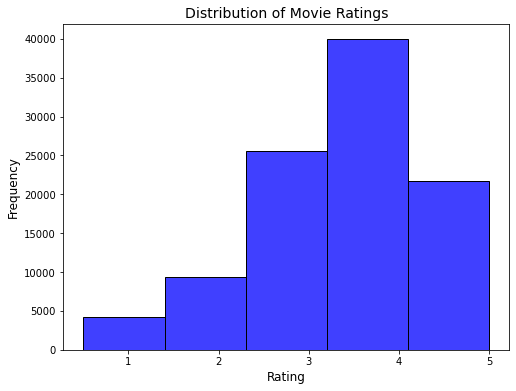

In [26]:
plt.figure(figsize=(8, 6))
sns.histplot(movie_rating['rating'], bins=5, kde=False, color='blue')  


plt.title('Distribution of Movie Ratings', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.show()

- Rating `4` has the highest frequency followed by 3,5,2 and 1 respectively.

### 3.2 Top 10 Movies by Average rating


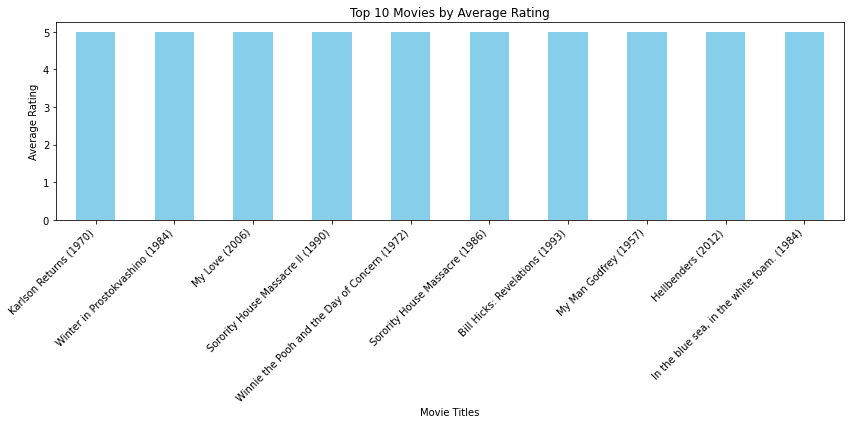

In [27]:
avg_ratings = movie_ratingv.groupby('title')['rating'].mean()


avg_ratings_sorted = avg_ratings.sort_values(ascending=False)


top_n = 10
top_movies = avg_ratings_sorted.head(top_n)

plt.figure(figsize=(12, 6))
top_movies.plot(kind='bar', color='skyblue')
plt.title(f'Top {top_n} Movies by Average Rating')
plt.xlabel('Movie Titles')
plt.ylabel('Average Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 3.3 Genre popularity

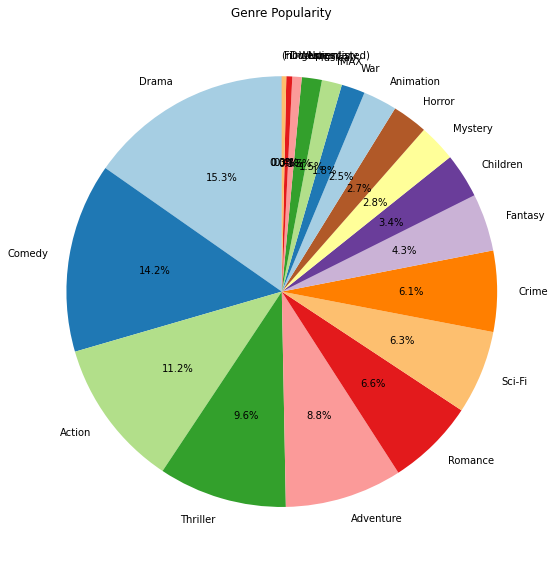

In [28]:
genres_series = movie_ratingv['genres'].str.split('|', expand=True).stack()

# Count the frequency of each genre
genre_counts = genres_series.value_counts()

 #Plot the pie chart for genre popularity
plt.figure(figsize=(8, 8))
genre_counts.plot(kind='pie', autopct='%1.1f%%', colors=plt.cm.Paired.colors, startangle=90, legend=False)
plt.title('Genre Popularity')
plt.ylabel('')  # Hide the y-label
plt.tight_layout()
plt.show()

- Drama, Comedy and action are the 3 the most popular genres

### 3.4 Ratings Distribution by Genre

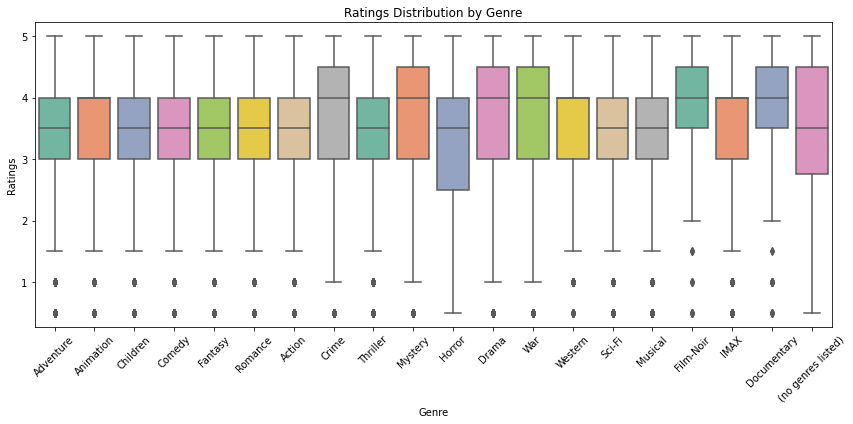

In [29]:
expanded_movie_rating = movie_ratingv.assign(genres=movie_ratingv['genres'].str.split('|')).explode('genres')

#  Create a box plot for ratings by genre
plt.figure(figsize=(12, 6))
sns.boxplot(x='genres', y='rating', data=expanded_movie_rating, palette='Set2')

plt.title('Ratings Distribution by Genre')
plt.xlabel('Genre')
plt.ylabel('Ratings')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

### 3.5 Genre- Rating correlation heatmap

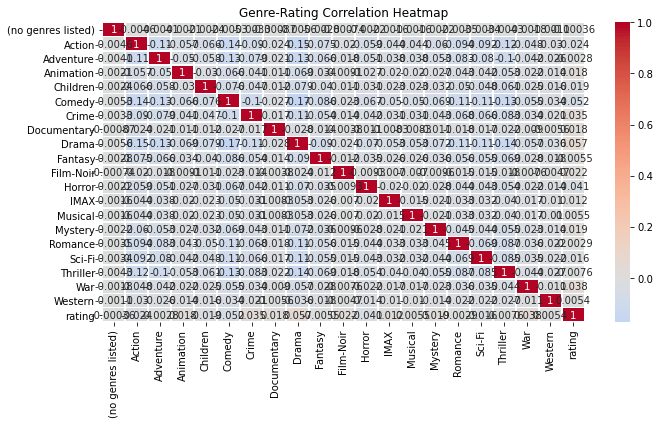

In [30]:
expanded_movie_rating = movie_ratingv.assign(genres=movie_ratingv['genres'].str.split('|')).explode('genres')


genre_dummies = pd.get_dummies(expanded_movie_rating['genres'])


genre_ratings_df = pd.concat([genre_dummies, expanded_movie_rating['rating']], axis=1)

# Calculate the correlation between genres and ratings
correlation_matrix = genre_ratings_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Genre-Rating Correlation Heatmap')
plt.tight_layout()
plt.show()

### **4.0 Data preparation for surprise**


- Surprise is a liblary used to build recommendation systems

- Surprise  offers several algorithms for collaborative filtering (e.g., Singular Value Decomposition, K-Nearest Neighbors).

- It provides tools for evaluating the performance of models using standard metrics.

In [31]:
reader = Reader (rating_scale= (0.5, 5.0))
data = Dataset.load_from_df(movie_rating[["userId", "movieId", "rating"]], reader)
data

`Reader`: This is a class in the surprise library that is used to parse the rating data

`rating_scale=(0.5, 5.0)`: This parameter sets the acceptable range for ratings in the dataset. In this case, ratings can only be between 0.5 and 5.0

`Dataset`: This is a class in surprise that represents a dataset of user-item interactions (ratings, in this case). It's the format that surprise expects to work with for training models.

`load_from_df`: This method is used to load a dataset from a pandas DataFrame into a format that surprise can work with.

In [32]:
dataset = data.build_full_trainset()

`build_full_trainset()` is used to generate a trainset from the Data

In [33]:

print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  610 

Number of items:  9724


looking at how many users and items we have in our dataset. when using neighborhood-based methods, this helps in determining whether or not we should perform user-user or item-item similarity.

from the dataset, we will be using the user-based systems

### 4.1 Modeling with SVD using gridsearch

- `GridSearch` is a technique used to find the best combination of hyperparameters

In [34]:
params = {'n_factors': [30, 50, 100], 
          'reg_all':[0.02,0.03,0.05]}
grid_s_svd = GridSearchCV(SVD, param_grid=params)
grid_s_svd.fit(data)

In [35]:
print(grid_s_svd.best_score)
print(grid_s_svd.best_params)

{'rmse': 0.8693113302790063, 'mae': 0.6682294978506855}
{'rmse': {'n_factors': 30, 'reg_all': 0.05}, 'mae': {'n_factors': 30, 'reg_all': 0.02}}


- ` rmse` for the SVD is around 86.93%
- ` gridsearch` best parameters are `n_factors = 30` and `reg_all = 0.03`

### 4.2 cross validating with KNNBasic

In [36]:
knn_basic = KNNBasic(sim_options= {'name': 'pearson', 'user_based': True})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs = 1)
cv_knn_basic['test_rmse']
print(np.mean(cv_knn_basic['test_rmse']))

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
0.972061182269172


- `test_rmse` for this model is around 97.36 % an improvement from SVD

- `pearson` is the similarity metrics 

- ` KNNBasic` for computing the similarity scores and making predictions

- ` User_based = TRUE` a type of filtering for user_based system

### 4.3 cross validating with KNNBaseline

In [37]:
knn_baseline = KNNBaseline(sim_options={'name':'pearson','user_based': True})
cv_knn_baseline = cross_validate(knn_baseline, data, n_jobs= 1)
cv_knn_baseline['test_rmse']
print(np.mean(cv_knn_baseline['test_rmse']))

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
0.877427329039614


- ` test_rmse` for this model is around 87.67
%

### 4.4 cross validating with KNNWithMeans

In [38]:
knn_with_means = KNNWithMeans(sim_options={'name':'pearson','user_based': True})
cv_knn_with_means = cross_validate(knn_with_means, data, n_jobs= 1)
cv_knn_with_means['test_rmse']
print(np.mean(cv_knn_with_means['test_rmse']))

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
0.8962013839818613


- ` test_rmse` for this model is around 89.74%


`RMSE` is used to evaluate the accuracy of predicted ratings. It measures the average difference between predicted and actual ratings (how close or far apart the predictions are from the actual values).

`Lower RMSE` indicates a better fit of the model

From the above outputs, SVD seems to be the best performing model with a test RMSE of around `86.85 %`

We will therefore use SVD to make predictions

### **5.0 Using the best Model for predictions**

In [39]:
svd = SVD(n_factors= 30, reg_all=0.05)
svd.fit(dataset)

### 5.1 User ratings

- The function below allows a user to rate a certain number of movies on a scale from 1 to 5 or skip movies they haven’t seen

In [40]:
def movie_rater(movie_df,num, genre=None):
    userID = 1000
    rating_list = []
    while num > 0:
        if genre:
            movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list

In [41]:
user_rating = movie_rater(movies, 10, 'Comedy')

    movieId                                       title  \
99      112  Rumble in the Bronx (Hont faan kui) (1995)   

                           genres  
99  Action|Adventure|Comedy|Crime  
     movieId                               title        genres
850     1120  People vs. Larry Flynt, The (1996)  Comedy|Drama
      movieId                            title  genres
9273   157270  Barbershop: The Next Cut (2016)  Comedy
      movieId                title               genres
5976    36363  Kin-Dza-Dza! (1986)  Comedy|Drama|Sci-Fi
      movieId                                 title              genres
2890     3865  Original Kings of Comedy, The (2000)  Comedy|Documentary
      movieId        title              genres
1952     2587  Life (1999)  Comedy|Crime|Drama
      movieId         title          genres
2695     3616  Loser (2000)  Comedy|Romance
      movieId              title          genres
7973    96530  Conception (2011)  Comedy|Romance
      movieId                   title

### 5.2 Predictions with the new rating

In [42]:
user_ratings = pd.DataFrame(user_rating)
new_ratings_df = pd.concat([movie_rating, user_ratings], axis=0)
new_data = Dataset.load_from_df(new_ratings_df,reader)


**Explanation**

- Creating a DataFrame (user_ratings) from a list of dictionaries (user_rating).

- Concatenate the movie_rating DataFrame  with the newly created user_ratings DataFrame to form a DataFrame (new_ratings_df).

- Load the concatenated DataFrame (new_ratings_df) into the surprise library’s Dataset format using Dataset.load_from_df()

### 5.3 training the model with the new Data

In [43]:
svd_ = SVD(n_factors= 30, reg_all=0.05)
svd_.fit(new_data.build_full_trainset())

- the model (svd_) is trained and ready to make predictions about how a user might rate movies they haven’t seen yet

### 5.4 making predictions for the user and ordering the predictions from highest to lowest rated

In [44]:
list_of_movies = []
for m_id in movie_rating['movieId'].unique():
    list_of_movies.append( (m_id,svd_.predict(1000,m_id)[3]))
ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)

- The ranked_movies list contains a sorted list of tuples, where each tuple consists of a movie ID and the predicted rating for user 1000. The list is ordered from the movie with the highest predicted rating to the lowest.

### **6.0 making recommendations**

In [45]:
def recommended_movies(user_ratings,movie_title_df,n):
        for idx, rec in enumerate(user_ratings):
            title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n-= 1
            if n == 0:
                break
            
recommended_movies(ranked_movies,movies,5)

Recommendation #  1 :  602    Dr. Strangelove or: How I Learned to Stop Worr...
Name: title, dtype: object 

Recommendation #  2 :  277    Shawshank Redemption, The (1994)
Name: title, dtype: object 

Recommendation #  3 :  906    Lawrence of Arabia (1962)
Name: title, dtype: object 

Recommendation #  4 :  2226    Fight Club (1999)
Name: title, dtype: object 

Recommendation #  5 :  922    Godfather: Part II, The (1974)
Name: title, dtype: object 



**Output Explanation**



`Recommendation # 1`: The code looks for the movie title that corresponds to movieId 277, which is "Dr. Strangelove".

`Recommendation # 2`: It then looks for movieId 277, which corresponds to "The Shawshank Redemption (1994)".

`Recommendation # 3`: for movieId 906, it finds "Lawrence of Arabia (1962)".

`Recommendation # 4`: Next, for movieId 2226, it finds "Fight Club (1999)".

`Recommendation # 5`: Finally, for movieId 922, it finds " Godfather: Part II, The (1974)".